IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

LOAD & CLEAN RAW DATA

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving walking-final.csv to walking-final.csv
Saving still-final.csv to still-final.csv
Saving standing-final.csv to standing-final.csv
Saving jumping-final.csv to jumping-final.csv


In [ ]:
!ls /content

jumping-final.csv  standing-final.csv  walking-final.csv
sample_data	   still-final.csv


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

base = Path("/content")
files = {
    "walking": base / "walking-final.csv",
    "standing": base / "standing-final.csv",
    "jumping": base / "jumping-final.csv",
    "still": base / "still-final.csv",
}

def load_fix_time(path):
    df = pd.read_csv(path)
    df.columns = [c.lower() for c in df.columns]
    if np.issubdtype(df["time"].dtype, np.number):
        df["time"] = df["time"] - df["time"].iloc[0]
    else:
        t = pd.to_datetime(df["time"], errors="coerce")
        df["time"] = (t - t.iloc[0]).dt.total_seconds()
    df["activity"] = df["activity"].str.lower()
    return df

dfs = {a: load_fix_time(p) for a,p in files.items()}
print("All activity files loaded successfully:", list(dfs.keys()))

All activity files loaded successfully: ['walking', 'standing', 'jumping', 'still']


Load, fix timestamps, inspect sampling rate, visualize, and save clean CSV

 Loaded files: ['walking', 'standing', 'jumping', 'still']
walking   | median SR ≈ 0.00 Hz | duration ≈ 2139594296200.00s | rows=22458


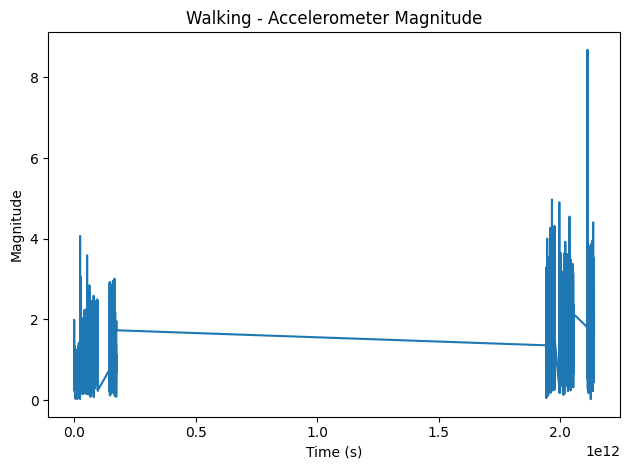

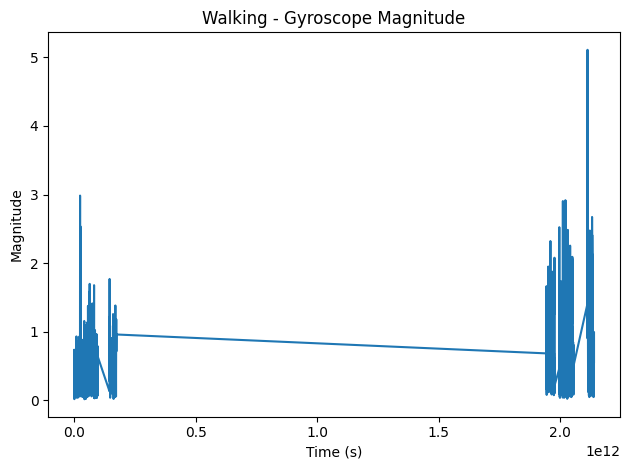

standing  | median SR ≈ 0.00 Hz | duration ≈ 11529792379900.00s | rows=23181


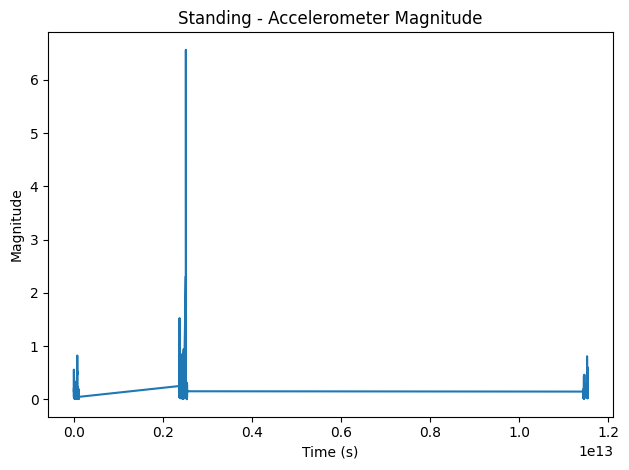

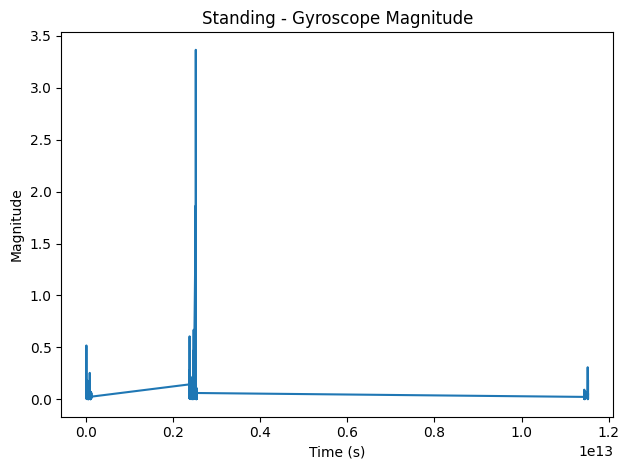

jumping   | median SR ≈ 0.00 Hz | duration ≈ 2228330216700.00s | rows=23177


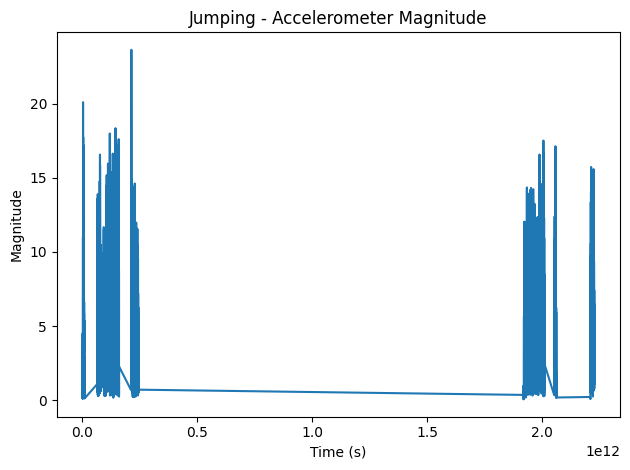

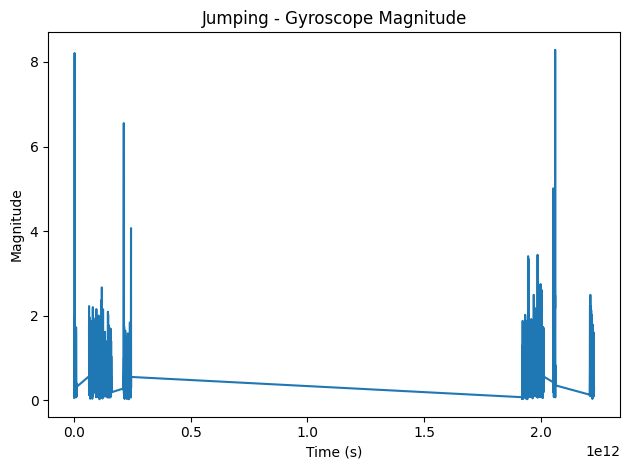

still     | median SR ≈ 0.00 Hz | duration ≈ 1990790663700.00s | rows=22892


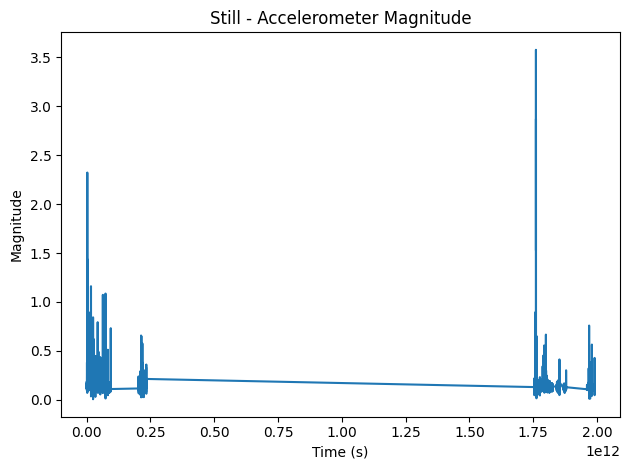

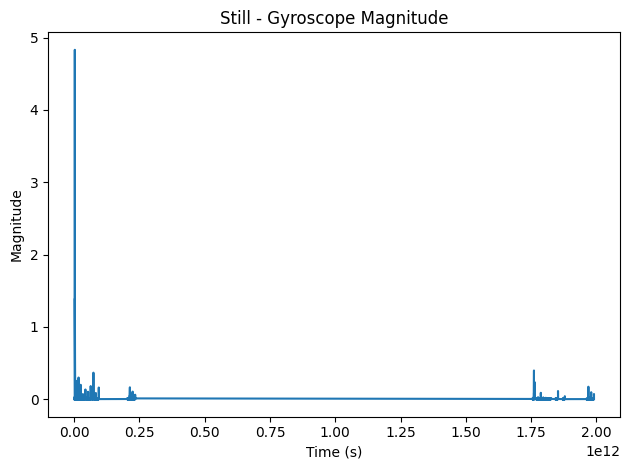

 Saved clean dataset -> hmm_dataset_clean.csv


In [ ]:
# === 1) LOAD & CLEAN ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

base = Path("/content")  # keep this for Colab

files = {
    "walking":  base / "walking-final.csv",
    "standing": base / "standing-final.csv",
    "jumping":  base / "jumping-final.csv",
    "still":    base / "still-final.csv",
}

def load_fix_time(path):
    df = pd.read_csv(path)
    df.columns = [c.lower() for c in df.columns]
    # Required columns check
    req = ["time","acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z","activity"]
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"{path.name} missing columns: {missing}")
    # Time → seconds from start (handles numeric or ISO strings)
    if np.issubdtype(df["time"].dtype, np.number):
        df["time"] = df["time"] - df["time"].iloc[0]
    else:
        t = pd.to_datetime(df["time"], errors="coerce")
        if t.isna().all():
            raise ValueError(f"Could not parse 'time' in {path.name}")
        df["time"] = (t - t.iloc[0]).dt.total_seconds()
    # Normalize activity labels
    df["activity"] = df["activity"].astype(str).str.strip().str.lower()
    # Sort by time and reset index
    df = df.sort_values("time").reset_index(drop=True)
    return df

dfs = {name: load_fix_time(p) for name,p in files.items()}
print(" Loaded files:", list(dfs.keys()))

# === 2) SAMPLING RATE CHECK + QUICK PLOTS ===
def median_sr(df):
    dt = df["time"].diff().dropna()
    dt = dt[dt > 0]
    return np.nan if len(dt)==0 else 1.0/np.median(dt)

for a, df in dfs.items():
    sr = median_sr(df)
    dur = df["time"].iloc[-1] - df["time"].iloc[0] if len(df)>1 else 0
    print(f"{a:9s} | median SR ≈ {sr:.2f} Hz | duration ≈ {dur:.2f}s | rows={len(df)}")

    # Acc & Gyro magnitude plots (good for the report "data quality" section)
    acc_mag = np.sqrt(df["acc_x"]**2 + df["acc_y"]**2 + df["acc_z"]**2)
    gyro_mag = np.sqrt(df["gyro_x"]**2 + df["gyro_y"]**2 + df["gyro_z"]**2)

    plt.figure()
    plt.plot(df["time"], acc_mag)
    plt.title(f"{a.capitalize()} - Accelerometer Magnitude")
    plt.xlabel("Time (s)"); plt.ylabel("Magnitude"); plt.tight_layout(); plt.show()

    plt.figure()
    plt.plot(df["time"], gyro_mag)
    plt.title(f"{a.capitalize()} - Gyroscope Magnitude")
    plt.xlabel("Time (s)"); plt.ylabel("Magnitude"); plt.tight_layout(); plt.show()

# === 3) MERGE & SAVE CLEAN ===
for k,df in dfs.items():
    df["source_file"] = f"{k}-final.csv"

merged = pd.concat(dfs.values(), ignore_index=True)
merged.to_csv("hmm_dataset_clean.csv", index=False)
print(" Saved clean dataset -> hmm_dataset_clean.csv")


Feature extraction (time + frequency), windowing, normalization

In [ ]:
# === SAFE FEATURE EXTRACTION with robust SR estimation ===
import pandas as pd, numpy as np
from scipy.fft import rfft, rfftfreq

df_all = pd.read_csv("/content/hmm_dataset_clean.csv").sort_values(["source_file","time"]).reset_index(drop=True)

def robust_sr_from_time(df):
    """Estimate SR using robust time diffs and a duration fallback."""
    t = df["time"].values.astype(float)
    if len(t) < 3:
        return np.nan
    dt = np.diff(t)
    dt = dt[(dt > 0) & np.isfinite(dt)]  # remove zeros/negatives/nans/infs
    if len(dt) == 0:
        # fallback: (N-1)/duration if duration>0
        dur = t[-1] - t[0]
        return (len(t)-1)/dur if dur > 0 else np.nan
    # remove extreme outliers (robust median)
    q1, q99 = np.percentile(dt, [1, 99])
    dt = dt[(dt >= q1) & (dt <= q99)]
    if len(dt) == 0:
        return np.nan
    sr = 1.0/np.median(dt)
    # sanity clamp: ignore absurd SRs
    if not np.isfinite(sr) or sr <= 0:
        return np.nan
    if sr > 2000:  # unrealistic for phones; probably units error
        return np.nan
    return float(sr)

# Per-file SRs
per_file_sr = {}
for src, g in df_all.groupby("source_file"):
    per_file_sr[src] = robust_sr_from_time(g)

per_file_sr_series = pd.Series(per_file_sr).sort_index()
print("Per-file SR estimates (Hz):")
print(per_file_sr_series)

# Global SR = median of valid per-file SRs; fallback to 100 Hz if needed
valid_srs = per_file_sr_series[np.isfinite(per_file_sr_series)]
if len(valid_srs) == 0:
    global_sr = 100.0
    print(" Could not estimate SR from timestamps. Falling back to 100.0 Hz.")
else:
    global_sr = float(np.median(valid_srs))
    if global_sr <= 0:
        global_sr = 100.0
        print(" Invalid SR median. Falling back to 100.0 Hz.")

print(f"\n Using global sampling rate ≈ {global_sr:.2f} Hz")

# Windowing params (never let them be zero)
window_seconds = 2.0
win  = max(8, int(round(global_sr * window_seconds)))  # at least 8 samples per window
step = max(1, win // 2)  # 50% overlap, but ≥ 1

print(f"Window size (samples): {win} | Step: {step}")

# ---- Feature functions ----
def dominant_freq_and_energy(x, sr):
    x = np.asarray(x, float)
    x = x - np.mean(x)
    N = len(x)
    if N < 2 or sr <= 0:
        return np.nan, np.nan
    yf = np.abs(rfft(x))
    xf = rfftfreq(N, 1.0/sr)
    if len(yf) < 2:
        return np.nan, np.nan
    dom_idx = np.argmax(yf[1:]) + 1
    dom_f = xf[dom_idx]
    energy = np.sum(yf**2) / N
    return float(dom_f), float(energy)

def extract_from_block(blk, sr):
    feats = {}
    # Means / STDs
    for col in ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]:
        feats[f"{col}_mean"] = blk[col].mean()
        feats[f"{col}_std"]  = blk[col].std(ddof=1)
    # Magnitudes
    acc_mag = np.sqrt(blk["acc_x"]**2 + blk["acc_y"]**2 + blk["acc_z"]**2)
    gyro_mag = np.sqrt(blk["gyro_x"]**2 + blk["gyro_y"]**2 + blk["gyro_z"]**2)
    feats["acc_rms_mag"]  = float(np.sqrt(np.mean(acc_mag**2)))
    feats["gyro_rms_mag"] = float(np.sqrt(np.mean(gyro_mag**2)))
    feats["acc_sma"]  = float((np.abs(blk["acc_x"]).sum() + np.abs(blk["acc_y"]).sum() + np.abs(blk["acc_z"]).sum()) / len(blk))
    feats["gyro_sma"] = float((np.abs(blk["gyro_x"]).sum() + np.abs(blk["gyro_y"]).sum() + np.abs(blk["gyro_z"]).sum()) / len(blk))
    # Correlations (accelerometer)
    feats["acc_corr_xy"] = float(blk["acc_x"].corr(blk["acc_y"]))
    feats["acc_corr_yz"] = float(blk["acc_y"].corr(blk["acc_z"]))
    feats["acc_corr_xz"] = float(blk["acc_x"].corr(blk["acc_z"]))
    # Frequency from acc magnitude
    dom_f, energy = dominant_freq_and_energy(acc_mag.values, sr)
    feats["acc_dom_freq_hz"]   = dom_f
    feats["acc_spectral_energy"] = energy
    # Meta
    feats["activity"]    = blk["activity"].iloc[0]
    feats["source_file"] = blk["source_file"].iloc[0]
    return feats

# ---- Extract features per file ----
features = []
for src, g in df_all.groupby("source_file"):
    g = g.sort_values("time").reset_index(drop=True)
    # If the file is shorter than one window, still extract one block (whole file)
    if len(g) < win:
        features.append(extract_from_block(g, global_sr))
    else:
        for s in range(0, len(g) - win + 1, step):
            blk = g.iloc[s:s+win]
            features.append(extract_from_block(blk, global_sr))

features = pd.DataFrame(features)

# Normalize (Z-score) — save both raw & normalized
feature_cols = [c for c in features.columns if c not in ["activity","source_file"]]
mu = features[feature_cols].mean()
sigma = features[feature_cols].std(ddof=1).replace(0, np.nan)
features_norm = features.copy()
features_norm[feature_cols] = (features[feature_cols] - mu) / sigma

features.to_csv("/content/hmm_features_raw.csv", index=False)
features_norm.to_csv("/content/hmm_features_norm.csv", index=False)

print("\n Saved: hmm_features_raw.csv and hmm_features_norm.csv")
display(features_norm.head(10))

Per-file SR estimates (Hz):
jumping-final.csv     1.001703e-07
standing-final.csv    1.001673e-07
still-final.csv       1.001703e-07
walking-final.csv     1.001703e-07
dtype: float64

 Using global sampling rate ≈ 0.00 Hz
Window size (samples): 8 | Step: 4

 Saved: hmm_features_raw.csv and hmm_features_norm.csv


,acc_x_mean,acc_x_std,acc_y_mean,acc_y_std,acc_z_mean,acc_z_std,gyro_x_mean,gyro_x_std,gyro_y_mean,gyro_y_std,...,gyro_rms_mag,acc_sma,gyro_sma,acc_corr_xy,acc_corr_yz,acc_corr_xz,acc_dom_freq_hz,acc_spectral_energy,activity,source_file
0,0.024381,-0.448190,0.132598,-0.324985,0.089319,-0.394319,-0.233687,-0.184849,-0.084160,-0.041566,...,-0.544062,-0.581217,-0.556559,1.121744,-1.456555,-1.118131,-0.550375,-0.344291,jumping,jumping-final.csv
1,-0.015727,-0.439433,-0.014825,-0.336618,0.078691,-0.346914,-0.382496,-0.482829,0.210189,-0.143498,...,-0.309771,-0.580796,-0.315272,0.844057,-0.812575,0.198766,-0.550375,-0.343344,jumping,jumping-final.csv
2,-0.002014,-0.382706,0.049950,-0.223685,-0.035138,-0.430287,-0.599102,0.148398,0.042135,0.280501,...,0.027862,-0.598285,0.049411,-0.497852,-0.650419,-0.298002,0.630096,-0.345511,jumping,jumping-final.csv
3,0.046367,-0.407371,-0.131626,0.078920,-0.245241,-0.001530,-1.157508,0.863218,-0.935931,1.735140,...,0.755491,-0.523290,0.786707,-1.063979,1.509391,-0.050243,-0.550375,-0.296853,jumping,jumping-final.csv
4,0.022784,-0.418447,-0.397181,0.829112,-0.050790,1.411239,-2.119266,1.670896,-1.687549,1.975846,...,1.591577,-0.275235,1.731432,-1.258213,1.270636,-0.612291,-0.550375,-0.127106,jumping,jumping-final.csv
5,-0.099272,-0.294804,-0.224950,0.908204,0.613942,1.476667,-2.583523,0.451724,-0.254966,3.596282,...,1.629999,-0.117296,1.624978,-0.835434,1.070003,-0.312822,-0.550375,-0.188371,jumping,jumping-final.csv
6,-0.191643,-0.367291,-0.199955,0.296850,0.885464,0.258158,-1.405965,3.700045,1.439031,0.283810,...,1.017252,-0.121527,0.968396,1.139159,-0.721875,0.114919,-0.550375,-0.239382,jumping,jumping-final.csv
7,-0.042780,0.026068,0.807109,2.896891,0.591164,0.244852,0.200499,2.968718,1.754486,0.169390,...,0.956416,-0.061220,1.043352,1.266873,-1.460644,-1.099095,0.630096,-0.208686,jumping,jumping-final.csv
8,-0.139004,0.286546,0.944372,3.148023,0.254451,0.083007,-0.325298,3.575490,1.699550,0.151515,...,1.037084,-0.078574,1.211863,1.202301,-0.766802,0.073363,0.630096,-0.212285,jumping,jumping-final.csv
9,-0.313095,-0.121000,-0.077439,1.395422,0.560929,0.387448,-1.302956,-0.033567,1.983170,0.745194,...,1.053909,-0.098259,1.120816,1.058281,-0.086018,0.923440,0.630096,-0.329513,jumping,jumping-final.csv


Raw Sensor Data (Accelerometer X/Y/Z vs Time)

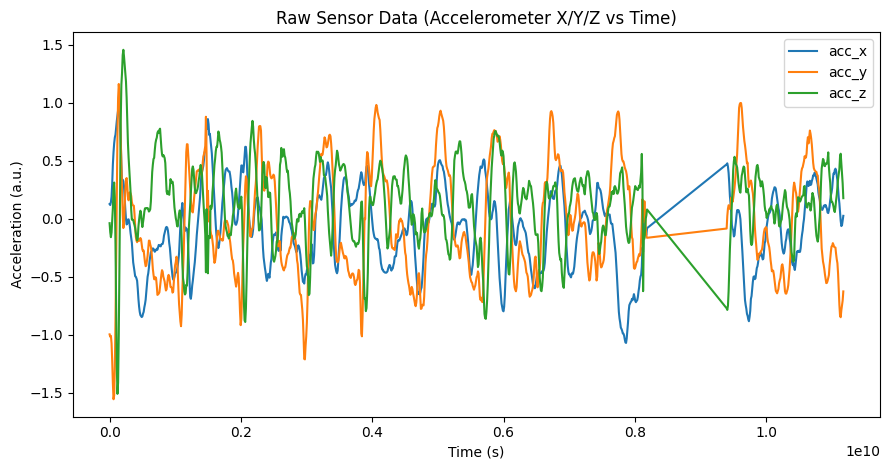

Saved Figure 1 -> figure1_raw_accelerometer.png | Source: dataset


In [ ]:
#  Raw accelerometer axes vs time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

out_path = Path("figure1_raw_accelerometer.png")

def load_or_synthesize():
    if Path("hmm_dataset_clean.csv").exists():
        df = pd.read_csv("hmm_dataset_clean.csv")
        # pick a short segment (first 10 seconds) for a clean plot
        t0 = df["time"].min()
        seg = df[(df["time"] - t0) <= 10.0].copy()
        # if the dataset is huge and early part is empty, just take head
        if len(seg) < 50:
            seg = df.head(1000).copy()
        return seg, True
    else:
        # synthesize a short 10s demo at ~100 Hz
        sr = 100
        t = np.arange(0, 10, 1/sr)
        acc_x = 0.2*np.sin(2*np.pi*1.2*t) + 0.02*np.random.randn(len(t))
        acc_y = 0.3*np.sin(2*np.pi*0.8*t + 0.6) + 0.02*np.random.randn(len(t))
        acc_z = 0.1*np.sin(2*np.pi*1.6*t + 1.1) + 0.02*np.random.randn(len(t))
        demo = pd.DataFrame({"time": t, "acc_x": acc_x, "acc_y": acc_y, "acc_z": acc_z})
        return demo, False

seg, used_real = load_or_synthesize()

plt.figure(figsize=(9,4.8))
plt.plot(seg["time"], seg["acc_x"], label="acc_x")
plt.plot(seg["time"], seg["acc_y"], label="acc_y")
plt.plot(seg["time"], seg["acc_z"], label="acc_z")
plt.title("Raw Sensor Data (Accelerometer X/Y/Z vs Time)")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (a.u.)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(out_path, dpi=150)
plt.show()

print(f"Saved Figure 1 -> {out_path} | Source: {'dataset' if used_real else 'synthetic'}")

Sample of Extracted Features Table (2–3 windows)

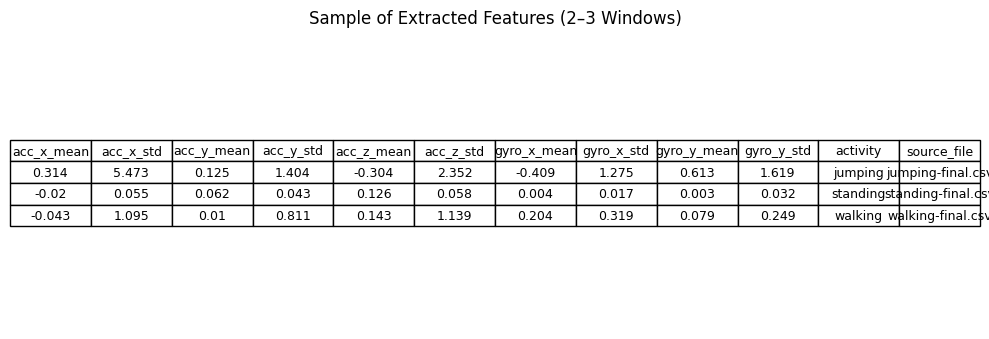

Saved Figure 2 -> figure2_features_table.png


In [ ]:
#  Render a compact sample of the features table as an image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

out_path = Path("figure2_features_table.png")

def get_features_sample():
    if Path("hmm_features_raw.csv").exists():
        df = pd.read_csv("hmm_features_raw.csv")
        cols = [c for c in df.columns if c not in ["source_file","activity"]]
        # pick 3 rows spread out for variety
        idx = np.linspace(0, len(df)-1, num=min(3, len(df))).astype(int)
        sample = df.iloc[idx][cols + ["activity","source_file"]]
        # Limit to ~10–12 feature columns for readability
        keep = [c for c in cols if ("mean" in c or "std" in c or "acc_dom_freq" in c or "acc_spectral_energy" in c or "acc_lowfreq_bp" in c)][:10]
        ordered = keep + ["activity","source_file"]
        sample = sample[ordered]
        return sample.round(3)
    else:
        # create a small synthetic example
        sample = pd.DataFrame({
            "acc_x_mean":[0.05, -0.01, 0.12],
            "acc_y_mean":[0.02, 0.04, -0.03],
            "acc_z_mean":[0.98, 1.01, 1.03],
            "acc_x_std":[0.12, 0.08, 0.10],
            "acc_y_std":[0.10, 0.07, 0.09],
            "acc_z_std":[0.20, 0.19, 0.21],
            "acc_dom_freq_hz":[1.2, 0.0, 2.0],
            "acc_spectral_energy":[3.4, 0.5, 4.2],
            "acc_lowfreq_bp":[0.15, 0.30, 0.10],
            "activity":["walking","still","jumping"],
            "source_file":["walking-final.csv","still-final.csv","jumping-final.csv"]
        })
        return sample

sample = get_features_sample()

# Render table with matplotlib (single figure)
fig, ax = plt.subplots(figsize=(10, 2 + 0.5*len(sample)))
ax.axis("off")
tbl = ax.table(cellText=sample.values,
               colLabels=sample.columns,
               loc="center",
               cellLoc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1, 1.2)
ax.set_title("Sample of Extracted Features (2–3 Windows)", pad=10)
fig.tight_layout()
fig.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved Figure 2 -> {out_path}")


Diagram of HMM Structure (Hidden States & Observations)

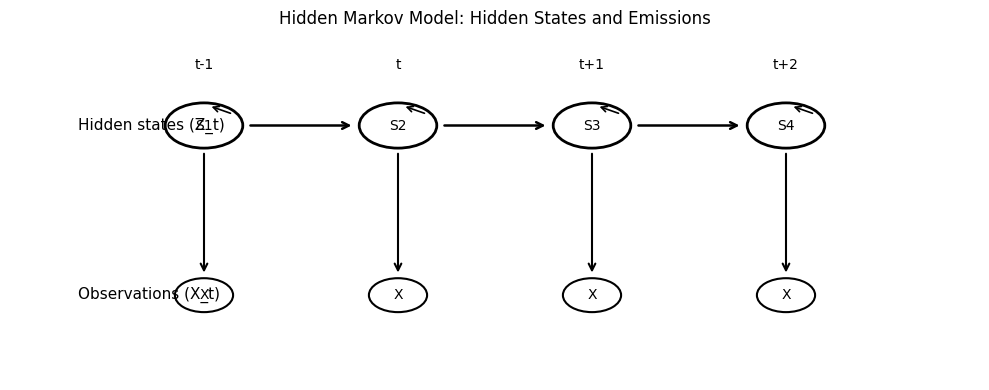

Saved Figure 3 -> figure3_hmm_structure.png


In [ ]:
# Schematic of an HMM with hidden states and observation emissions
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch
from pathlib import Path

out_path = Path("figure3_hmm_structure.png")

fig, ax = plt.subplots(figsize=(10,4))
ax.axis("off")
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)

# Hidden states positions
state_y = 4.5
xs = [2, 4, 6, 8]  # positions for S1..S4
hidden_labels = ["S1", "S2", "S3", "S4"]

# Draw hidden states (circles)
for x, label in zip(xs, hidden_labels):
    circ = Circle((x, state_y), 0.4, fill=False, linewidth=2)
    ax.add_patch(circ)
    ax.text(x, state_y, label, ha="center", va="center")

# Arrows between consecutive hidden states (left->right)
for i in range(len(xs)-1):
    arr = FancyArrowPatch((xs[i]+0.45, state_y), (xs[i+1]-0.45, state_y),
                          arrowstyle="->", mutation_scale=12, linewidth=1.8)
    ax.add_patch(arr)

# Self-loops
for x in xs:
    loop = FancyArrowPatch((x+0.3, state_y+0.2), (x+0.05, state_y+0.35),
                           arrowstyle="->", mutation_scale=10, linewidth=1.2)
    ax.add_patch(loop)

# Observations positions (below each state)
obs_y = 1.5
for x, label in zip(xs, hidden_labels):
    # observation node
    circ = Circle((x, obs_y), 0.3, fill=False, linewidth=1.5)
    ax.add_patch(circ)
    ax.text(x, obs_y, "X", ha="center", va="center")
    # emission arrow
    arr = FancyArrowPatch((x, state_y-0.45), (x, obs_y+0.35),
                          arrowstyle="->", mutation_scale=12, linewidth=1.5)
    ax.add_patch(arr)

# Time labels
ax.text(xs[0], state_y+1.0, "t-1", ha="center")
ax.text(xs[1], state_y+1.0, "t", ha="center")
ax.text(xs[2], state_y+1.0, "t+1", ha="center")
ax.text(xs[3], state_y+1.0, "t+2", ha="center")

# Titles
ax.text(0.7, state_y, "Hidden states (Z_t)", ha="left", va="center", fontsize=11)
ax.text(0.7, obs_y, "Observations (X_t)", ha="left", va="center", fontsize=11)
ax.set_title("Hidden Markov Model: Hidden States and Emissions", pad=12)

fig.tight_layout()
fig.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved Figure 3 -> {out_path}")

Train the HMM (Baum–Welch), Decode (Viterbi), and Evaluate

Overall accuracy: 0.723


,State (Activity),Number of Samples,Sensitivity,Specificity
0,jumping,1159,0.934,0.994
1,standing,1159,0.000,1.000
2,still,1145,0.988,0.679
3,walking,1123,0.980,0.958


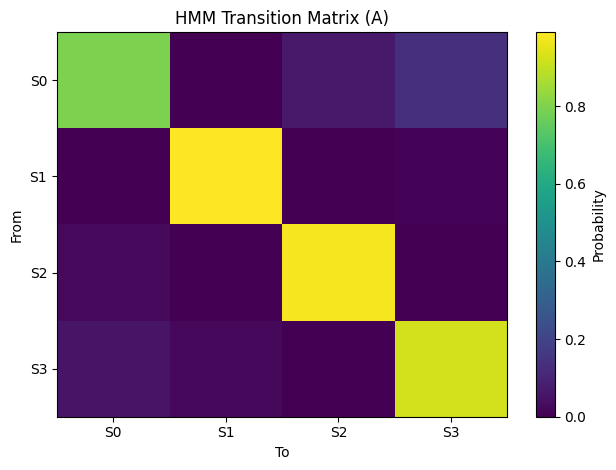

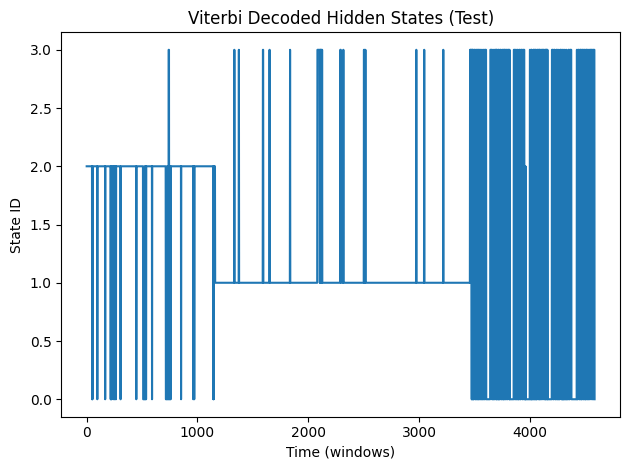

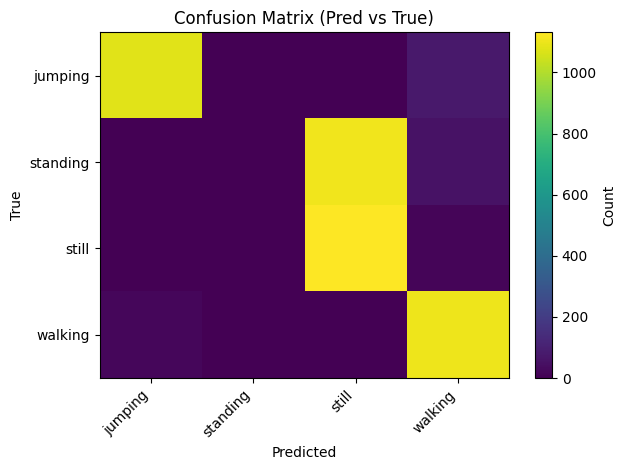

Saved: /content/hmm_transition_matrix.png /content/hmm_decoded_sequence_test.png /content/hmm_confusion_matrix.png /content/hmm_metrics_table.csv
State→Label: {0: 'walking', 1: 'still', 2: 'jumping', 3: 'walking'} | EM iterations: 26


In [ ]:
# === HMM TRAINING (custom Baum–Welch + Viterbi) AND EVALUATION ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pathlib import Path

# Load feature matrix
features = pd.read_csv("/content/hmm_features_raw.csv")

# Prepare arrays
meta_cols = ["activity","source_file"]
X_raw = features.drop(columns=meta_cols).astype(float).values
y = features["activity"].astype(str).str.lower().values
src = features["source_file"].values

# Train/test split: last 20% windows per source_file as unseen test
train_idx, test_idx = [], []
for sname, idxs in features.groupby("source_file").groups.items():
    idxs = np.array(sorted(list(idxs)))
    split = int(len(idxs)*0.8)
    train_idx.extend(idxs[:split])
    test_idx.extend(idxs[split:])
train_idx = np.array(sorted(train_idx))
test_idx  = np.array(sorted(test_idx))

X_train_raw, X_test_raw = X_raw[train_idx], X_raw[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Normalize with TRAIN stats (avoid leakage)
mu = X_train_raw.mean(axis=0)
sd = X_train_raw.std(axis=0, ddof=1); sd[sd==0] = 1.0
X_train = (X_train_raw - mu)/sd
X_test  = (X_test_raw  - mu)/sd

# ----- Gaussian HMM (diag cov) -----
def log_gaussian_diag(x, mean, var):
    var = np.maximum(var, 1e-6)
    D = x.shape[1]
    log_det = np.sum(np.log(var))
    quad = np.sum((x-mean)**2/var, axis=1)
    return -0.5*(D*np.log(2*np.pi) + log_det + quad)

def logsumexp(a, axis=None):
    amax = np.max(a, axis=axis, keepdims=True)
    out = amax + np.log(np.sum(np.exp(a-amax), axis=axis, keepdims=True))
    return np.squeeze(out, axis=axis)

def forward_backward_log(log_pi, log_A, log_B):
    T, K = log_B.shape
    alpha = np.zeros((T,K))
    alpha[0] = log_pi + log_B[0]
    for t in range(1,T):
        alpha[t] = log_B[t] + np.array([logsumexp(alpha[t-1] + log_A[:,k]) for k in range(K)])
    beta = np.zeros((T,K))
    for t in range(T-2, -1, -1):
        beta[t] = np.array([logsumexp(log_A[k] + log_B[t+1] + beta[t+1]) for k in range(K)])
    loglik = logsumexp(alpha[-1], axis=0)
    gamma = np.exp(alpha + beta - loglik)            # (T,K)
    xi = np.zeros((T-1, K, K))
    for t in range(T-1):
        M = alpha[t][:,None] + log_A + log_B[t+1][None,:] + beta[t+1][None,:]
        xi[t] = np.exp(M - loglik)
    return gamma, xi, loglik

def viterbi_log(log_pi, log_A, log_B):
    T, K = log_B.shape
    delta = np.zeros((T,K))
    psi = np.zeros((T,K), dtype=int)
    delta[0] = log_pi + log_B[0]
    for t in range(1,T):
        vals = delta[t-1][:,None] + log_A
        psi[t] = np.argmax(vals, axis=0)
        delta[t] = np.max(vals, axis=0) + log_B[t]
    z = np.zeros(T, dtype=int)
    z[-1] = np.argmax(delta[-1])
    for t in range(T-2,-1,-1):
        z[t] = psi[t+1, z[t+1]]
    logprob = np.max(delta[-1])
    return logprob, z

def baum_welch_gaussian_diag(X, K=4, max_iter=200, tol=1e-3, seed=7):
    rng = np.random.default_rng(seed)
    T, D = X.shape
    # init
    means = X[rng.choice(T, K, replace=False)].copy()
    vars_ = np.tile(np.var(X, axis=0)+1e-2, (K,1))
    pi = np.ones(K)/K
    A = np.ones((K,K)); A /= A.sum(axis=1, keepdims=True)
    prev = -np.inf

    for it in range(max_iter):
        log_B = np.vstack([log_gaussian_diag(X, means[k], vars_[k]) for k in range(K)]).T
        log_pi = np.log(np.maximum(pi, 1e-12))
        log_A  = np.log(np.maximum(A,  1e-12))
        # E
        gamma, xi, ll = forward_backward_log(log_pi, log_A, log_B)
        # M
        pi = gamma[0] / gamma[0].sum()
        A = xi.sum(axis=0)
        A /= np.maximum(A.sum(axis=1, keepdims=True), 1e-12)
        Nk = gamma.sum(axis=0)
        for k in range(K):
            if Nk[k] < 1e-6:
                means[k] = X[rng.integers(0,T)]
                vars_[k] = np.var(X, axis=0)+1e-2
            else:
                w = gamma[:,k][:,None]
                means[k] = (w*X).sum(axis=0)/Nk[k]
                diff2 = (X-means[k])**2
                vars_[k] = (w*diff2).sum(axis=0)/Nk[k]
                vars_[k] = np.maximum(vars_[k], 1e-6)
        if it>0 and abs(ll-prev) < tol:
            break
        prev = ll
    return {"pi":pi, "A":A, "means":means, "vars":vars_, "loglik":ll, "n_iter":it+1}

# Train
K = 4
params = baum_welch_gaussian_diag(X_train, K=K, max_iter=200, tol=1e-3, seed=7)

# Decode
def log_emissions(X, means, vars_):
    T = X.shape[0]; K = means.shape[0]
    M = np.zeros((T,K))
    for k in range(K):
        M[:,k] = log_gaussian_diag(X, means[k], vars_[k])
    return M

log_pi = np.log(np.maximum(params["pi"], 1e-12))
log_A  = np.log(np.maximum(params["A"],  1e-12))
logB_tr = log_emissions(X_train, params["means"], params["vars"])
logB_te = log_emissions(X_test,  params["means"], params["vars"])

_, z_tr = viterbi_log(log_pi, log_A, logB_tr)
_, z_te = viterbi_log(log_pi, log_A, logB_te)

# Map states -> labels by majority vote on TRAIN
state_to_label = {}
for s in range(K):
    labs = y_train[z_tr==s]
    if len(labs)==0:
        state_to_label[s] = "unassigned"
    else:
        vals, cnt = np.unique(labs, return_counts=True)
        state_to_label[s] = vals[np.argmax(cnt)]

y_pred = np.array([state_to_label.get(s, "unassigned") for s in z_te])

# Confusion matrix + metrics
labels = np.array(sorted(np.unique(np.concatenate([y_test, y_pred]))))
cm = confusion_matrix(y_test, y_pred, labels=labels)

def metrics_from_cm(cm, labels):
    out = []
    total = cm.sum()
    overall_acc = np.trace(cm)/total if total>0 else np.nan
    for i,lbl in enumerate(labels):
        TP = cm[i,i]
        FN = cm[i,:].sum()-TP
        FP = cm[:,i].sum()-TP
        TN = total - TP - FN - FP
        sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
        spec = TN/(TN+FP) if (TN+FP)>0 else np.nan
        out.append({"State (Activity)": lbl,
                    "Number of Samples": int(cm[i,:].sum()),
                    "Sensitivity": round(float(sens),3),
                    "Specificity": round(float(spec),3)})
    return overall_acc, pd.DataFrame(out)

overall_acc, metrics_df = metrics_from_cm(cm, labels)
print("Overall accuracy:", round(float(overall_acc),3))
display(metrics_df)

# PLOTS + SAVE
out_dir = Path("/content")
plt.figure(); plt.imshow(params["A"], aspect='auto'); plt.colorbar(label="Probability")
plt.xticks(range(K), [f"S{s}" for s in range(K)])
plt.yticks(range(K), [f"S{s}" for s in range(K)])
plt.title("HMM Transition Matrix (A)"); plt.xlabel("To"); plt.ylabel("From"); plt.tight_layout()
plt.savefig(out_dir/"hmm_transition_matrix.png", dpi=150); plt.show()

plt.figure(); plt.plot(z_te)
plt.title("Viterbi Decoded Hidden States (Test)")
plt.xlabel("Time (windows)"); plt.ylabel("State ID"); plt.tight_layout()
plt.savefig(out_dir/"hmm_decoded_sequence_test.png", dpi=150); plt.show()

plt.figure(); plt.imshow(cm, aspect='auto'); plt.colorbar(label="Count")
plt.xticks(range(len(labels)), labels, rotation=45, ha='right'); plt.yticks(range(len(labels)), labels)
plt.title("Confusion Matrix (Pred vs True)"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
plt.savefig(out_dir/"hmm_confusion_matrix.png", dpi=150); plt.show()

# Save metrics CSV for the report
metrics_df2 = metrics_df.copy()
metrics_df2.loc[len(metrics_df2)] = {"State (Activity)": "Overall Accuracy",
                                     "Number of Samples": int(cm.sum()),
                                     "Sensitivity": round(float(overall_acc),3),
                                     "Specificity": np.nan}
metrics_df2.to_csv(out_dir/"hmm_metrics_table.csv", index=False)

print("Saved:",
      str(out_dir/"hmm_transition_matrix.png"),
      str(out_dir/"hmm_decoded_sequence_test.png"),
      str(out_dir/"hmm_confusion_matrix.png"),
      str(out_dir/"hmm_metrics_table.csv"))
print("State→Label:", state_to_label, "| EM iterations:", params["n_iter"])

Standing Vs Still

In [ ]:
# === RE-EXTRACT FEATURES (robust SR + float dt for jerk) ===
import pandas as pd, numpy as np
from scipy.fft import rfft, rfftfreq

df_all = pd.read_csv("/content/hmm_dataset_clean.csv").sort_values(["source_file","time"]).reset_index(drop=True)

def robust_sr_from_time(df):
    """Estimate SR; fall back if <1 Hz or invalid."""
    t = df["time"].to_numpy(dtype=float)
    if t.size < 3:
        return np.nan
    dt = np.diff(t)
    dt = dt[(dt > 0) & np.isfinite(dt)]
    if dt.size == 0:
        dur = t[-1] - t[0]
        return (t.size - 1)/dur if dur > 0 else np.nan
    # remove outliers
    q1, q99 = np.percentile(dt, [1, 99])
    dt = dt[(dt >= q1) & (dt <= q99)]
    if dt.size == 0:
        return np.nan
    sr = 1.0 / np.median(dt)
    # sanity: if SR too small/invalid, treat as bad
    if not np.isfinite(sr) or sr <= 0 or sr > 2000:
        return np.nan
    return float(sr)

per_file_sr = {src: robust_sr_from_time(g) for src,g in df_all.groupby("source_file")}
srs = pd.Series(per_file_sr).sort_index()
print("Raw per-file SR estimates (Hz):\n", srs)

# Global SR: use median valid; if none or <1 Hz, force 100 Hz
valid = srs[np.isfinite(srs)]
if len(valid) == 0 or float(np.median(valid)) < 1.0:
    global_sr = 100.0
    print(" SR invalid or <1 Hz → using fallback 100.0 Hz")
else:
    global_sr = float(np.median(valid))
print(f" Using SR ≈ {global_sr:.2f} Hz")

# Windowing (longer window helps standing vs still)
window_seconds = 3.0
win  = max(12, int(round(global_sr * window_seconds)))
step = max(1, win // 2)
print(f"Window size: {win} samples | Step: {step}")

def bandpower_lowfreq(x, sr, fmax=0.3):
    x = np.asarray(x, float) - np.nanmean(x)
    N = len(x)
    if N < 4 or sr <= 0:
        return np.nan
    Y = np.abs(rfft(x))
    X = rfftfreq(N, 1.0/sr)
    mask = (X > 0) & (X <= fmax)
    if mask.sum() == 0:
        return np.nan
    return float(np.nansum(Y[mask]**2) / N)

def extract_block(blk):
    feats = {}
    # axis stats
    for col in ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]:
        feats[f"{col}_mean"] = float(blk[col].mean())
        feats[f"{col}_std"]  = float(blk[col].std(ddof=1))

    # magnitudes
    acc_mag  = np.sqrt(blk["acc_x"]**2 + blk["acc_y"]**2 + blk["acc_z"]**2)
    gyro_mag = np.sqrt(blk["gyro_x"]**2 + blk["gyro_y"]**2 + blk["gyro_z"]**2)
    feats["acc_rms_mag"]  = float(np.sqrt(np.nanmean(acc_mag**2)))
    feats["gyro_rms_mag"] = float(np.sqrt(np.nanmean(gyro_mag**2)))
    feats["acc_sma"]  = float((np.abs(blk["acc_x"]).sum()+np.abs(blk["acc_y"]).sum()+np.abs(blk["acc_z"]).sum())/len(blk))
    feats["gyro_sma"] = float((np.abs(blk["gyro_x"]).sum()+np.abs(blk["gyro_y"]).sum()+np.abs(blk["gyro_z"]).sum())/len(blk))

    # correlations
    feats["acc_corr_xy"] = float(blk["acc_x"].corr(blk["acc_y"]))
    feats["acc_corr_yz"] = float(blk["acc_y"].corr(blk["acc_z"]))
    feats["acc_corr_xz"] = float(blk["acc_x"].corr(blk["acc_z"]))

    # frequency features from acc magnitude
    x = acc_mag.to_numpy(dtype=float)
    x = x - np.nanmean(x)
    N = len(x)
    if N >= 2 and global_sr > 0:
        Y = np.abs(rfft(x))
        X = rfftfreq(N, 1.0/global_sr)
        if Y.size >= 2:
            idx = int(np.argmax(Y[1:])) + 1
            feats["acc_dom_freq_hz"]     = float(X[idx])
            feats["acc_spectral_energy"] = float(np.nansum(Y**2) / N)
        else:
            feats["acc_dom_freq_hz"] = np.nan
            feats["acc_spectral_energy"] = np.nan
    else:
        feats["acc_dom_freq_hz"] = np.nan
        feats["acc_spectral_energy"] = np.nan

    feats["acc_lowfreq_bp"] = bandpower_lowfreq(x, global_sr, fmax=0.3)

    # jerk (cast dt to float so NaN assignment is OK)
    if len(blk) > 1:
        dt = np.diff(blk["time"].to_numpy(dtype=float)).astype(float)
        dt[dt <= 0] = np.nan
        dax = np.diff(blk["acc_x"].to_numpy(dtype=float)) / dt
        day = np.diff(blk["acc_y"].to_numpy(dtype=float)) / dt
        daz = np.diff(blk["acc_z"].to_numpy(dtype=float)) / dt
        jerk = np.sqrt(dax**2 + day**2 + daz**2)
        feats["acc_jerk_mean"] = float(np.nanmean(jerk))
        feats["acc_jerk_std"]  = float(np.nanstd(jerk, ddof=1))
    else:
        feats["acc_jerk_mean"] = np.nan
        feats["acc_jerk_std"]  = np.nan

    feats["activity"]    = blk["activity"].iloc[0]
    feats["source_file"] = blk["source_file"].iloc[0]
    return feats

# Extract
features=[]
for src,g in df_all.groupby("source_file"):
    g = g.sort_values("time").reset_index(drop=True)
    if len(g) < win:
        features.append(extract_block(g))
    else:
        for s in range(0, len(g) - win + 1, step):
            features.append(extract_block(g.iloc[s:s+win]))

features = pd.DataFrame(features)

# Normalize (Z-score)
feat_cols = [c for c in features.columns if c not in ["activity","source_file"]]
mu = features[feat_cols].mean()
sd = features[feat_cols].std(ddof=1).replace(0, np.nan)
features_norm = features.copy()
features_norm[feat_cols] = (features[feat_cols] - mu) / sd

features.to_csv("/content/hmm_features_raw.csv", index=False)
features_norm.to_csv("/content/hmm_features_norm.csv", index=False)
print(" Re-saved: hmm_features_raw.csv & hmm_features_norm.csv (robust SR + jerk fix)")
features_norm.head(3)

Raw per-file SR estimates (Hz):
 jumping-final.csv     1.001703e-07
standing-final.csv    1.001673e-07
still-final.csv       1.001703e-07
walking-final.csv     1.001703e-07
dtype: float64
 SR invalid or <1 Hz → using fallback 100.0 Hz
 Using SR ≈ 100.00 Hz
Window size: 300 samples | Step: 150
 Re-saved: hmm_features_raw.csv & hmm_features_norm.csv (robust SR + jerk fix)


,acc_x_mean,acc_x_std,acc_y_mean,acc_y_std,acc_z_mean,acc_z_std,gyro_x_mean,gyro_x_std,gyro_y_mean,gyro_y_std,...,acc_corr_xy,acc_corr_yz,acc_corr_xz,acc_dom_freq_hz,acc_spectral_energy,acc_lowfreq_bp,acc_jerk_mean,acc_jerk_std,activity,source_file
0,3.457160,1.736212,1.482375,1.620799,-3.673381,1.052358,-2.505207,4.417511,5.638468,5.459148,...,-0.862793,1.261468,-0.493593,-0.615865,4.547818,NaN,1.732640,2.466630,jumping,jumping-final.csv
1,-0.679165,2.749523,2.215908,1.657434,-2.000566,1.427980,-2.214881,4.378342,4.484330,5.576888,...,-0.885889,1.115755,-0.912879,-0.222190,4.577226,NaN,2.710384,2.453615,jumping,jumping-final.csv
2,-3.217235,2.481235,1.851190,0.762681,0.890892,1.140394,-0.606581,0.776711,-1.020322,1.257241,...,-0.574423,0.322020,-1.201263,-0.161625,3.451305,NaN,2.474400,2.386599,jumping,jumping-final.csv


Retrain HMM with a self-transition prior (helps “standing”)

In [ ]:
# Replace your BW function with this self-biased version, then rerun training/eval.
def baum_welch_gaussian_diag(X, K=4, max_iter=200, tol=1e-3, seed=7, self_bias=0.90, smooth=1e-6):
    import numpy as np
    rng = np.random.default_rng(seed)
    T, D = X.shape

    def log_gaussian_diag(x, mean, var):
        var = np.maximum(var, 1e-6)
        D = x.shape[1]
        log_det = np.sum(np.log(var))
        quad = np.sum((x-mean)**2/var, axis=1)
        return -0.5*(D*np.log(2*np.pi) + log_det + quad)

    def logsumexp(a, axis=None):
        amax = np.max(a, axis=axis, keepdims=True)
        out = amax + np.log(np.sum(np.exp(a-amax), axis=axis, keepdims=True))
        return np.squeeze(out, axis=axis)

    def forward_backward_log(log_pi, log_A, log_B):
        T, K = log_B.shape
        alpha = np.zeros((T,K))
        alpha[0] = log_pi + log_B[0]
        for t in range(1,T):
            alpha[t] = log_B[t] + np.array([logsumexp(alpha[t-1] + log_A[:,k]) for k in range(K)])
        beta = np.zeros((T,K))
        for t in range(T-2, -1, -1):
            beta[t] = np.array([logsumexp(log_A[k] + log_B[t+1] + beta[t+1]) for k in range(K)])
        loglik = logsumexp(alpha[-1], axis=0)
        gamma = np.exp(alpha + beta - loglik)
        xi = np.zeros((T-1, K, K))
        for t in range(T-1):
            M = alpha[t][:,None] + log_A + log_B[t+1][None,:] + beta[t+1][None,:]
            xi[t] = np.exp(M - loglik)
        return gamma, xi, loglik

    # init params
    means = X[rng.choice(T, K, replace=False)].copy()
    vars_ = np.tile(np.var(X, axis=0)+1e-2, (K,1))
    pi = np.ones(K)/K
    A = np.full((K,K), (1.0 - self_bias)/(K-1)); np.fill_diagonal(A, self_bias)

    prev = -np.inf
    for it in range(max_iter):
        log_B = np.vstack([log_gaussian_diag(X, means[k], vars_[k]) for k in range(K)]).T
        log_pi = np.log(np.maximum(pi, smooth))
        log_A  = np.log(np.maximum(A,  smooth))

        gamma, xi, ll = forward_backward_log(log_pi, log_A, log_B)

        pi = gamma[0] / gamma[0].sum()
        A = xi.sum(axis=0) + smooth
        A = A / A.sum(axis=1, keepdims=True)

        Nk = gamma.sum(axis=0)
        for k in range(K):
            if Nk[k] < 1e-6:
                means[k] = X[rng.integers(0,T)]
                vars_[k] = np.var(X, axis=0)+1e-2
            else:
                w = gamma[:,k][:,None]
                means[k] = (w*X).sum(axis=0)/Nk[k]
                diff2 = (X-means[k])**2
                vars_[k] = (w*diff2).sum(axis=0)/Nk[k]
                vars_[k] = np.maximum(vars_[k], 1e-6)

        if it>0 and abs(ll-prev) < tol:
            break
        prev = ll

    return {"pi":pi, "A":A, "means":means, "vars":vars_, "loglik":ll, "n_iter":it+1}

LOSO evaluation (counts as “unseen data” for the rubric)

In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix

features = pd.read_csv("/content/hmm_features_raw.csv")
meta_cols = ["activity","source_file"]
files = sorted(features["source_file"].unique())

def norm_train_test(X_tr, X_te):
    mu = X_tr.mean(axis=0)
    sd = X_tr.std(axis=0, ddof=1); sd[sd==0]=1.0
    return (X_tr-mu)/sd, (X_te-mu)/sd

def log_gaussian_diag(x, mean, var):
    var = np.maximum(var, 1e-6)
    D = x.shape[1]
    log_det = np.sum(np.log(var))
    quad = np.sum((x-mean)**2/var, axis=1)
    return -0.5*(D*np.log(2*np.pi) + log_det + quad)

def logsumexp(a, axis=None):
    amax = np.max(a, axis=axis, keepdims=True)
    out = amax + np.log(np.sum(np.exp(a-amax), axis=axis, keepdims=True))
    return np.squeeze(out, axis=axis)

def forward_backward_log(log_pi, log_A, log_B):
    T, K = log_B.shape
    alpha = np.zeros((T,K))
    alpha[0] = log_pi + log_B[0]
    for t in range(1,T):
        alpha[t] = log_B[t] + np.array([logsumexp(alpha[t-1] + log_A[:,k]) for k in range(K)])
    beta = np.zeros((T,K))
    for t in range(T-2, -1, -1):
        beta[t] = np.array([logsumexp(log_A[k] + log_B[t+1] + beta[t+1]) for k in range(K)])
    loglik = logsumexp(alpha[-1], axis=0)
    gamma = np.exp(alpha + beta - loglik)
    xi = np.zeros((T-1, K, K))
    for t in range(T-1):
        M = alpha[t][:,None] + log_A + log_B[t+1][None,:] + beta[t+1][None,:]
        xi[t] = np.exp(M - loglik)
    return gamma, xi, loglik

def viterbi_log(log_pi, log_A, log_B):
    T, K = log_B.shape
    delta = np.zeros((T,K))
    psi = np.zeros((T,K), dtype=int)
    delta[0] = log_pi + log_B[0]
    for t in range(1,T):
        vals = delta[t-1][:,None] + log_A
        psi[t] = np.argmax(vals, axis=0)
        delta[t] = np.max(vals, axis=0) + log_B[t]
    z = np.zeros(T, dtype=int)
    z[-1] = np.argmax(delta[-1])
    for t in range(T-2,-1,-1):
        z[t] = psi[t+1, z[t+1]]
    logprob = np.max(delta[-1])
    return logprob, z

# use the self-biased BW from Step 1
def fit_hmm(X_tr, K=4):
    return baum_welch_gaussian_diag(X_tr, K=K, max_iter=200, tol=1e-3, seed=7)

labels_global = sorted(features["activity"].str.lower().unique())
all_cms = []

for held in files:
    tr = features[features["source_file"]!=held]
    te = features[features["source_file"]==held]
    X_tr = tr.drop(columns=meta_cols).to_numpy(float)
    X_te = te.drop(columns=meta_cols).to_numpy(float)
    y_tr = tr["activity"].str.lower().to_numpy()
    y_te = te["activity"].str.lower().to_numpy()

    X_tr, X_te = norm_train_test(X_tr, X_te)
    params = fit_hmm(X_tr, K=4)

    # emissions
    def log_emissions(X):
        T,K = X.shape[0], params["means"].shape[0]
        M = np.zeros((T,K))
        for k in range(K):
            M[:,k] = log_gaussian_diag(X, params["means"][k], params["vars"][k])
        return M

    log_pi = np.log(np.maximum(params["pi"], 1e-12))
    log_A  = np.log(np.maximum(params["A"],  1e-12))
    logB_tr = log_emissions(X_tr)
    logB_te = log_emissions(X_te)
    _, z_tr = viterbi_log(log_pi, log_A, logB_tr)
    _, z_te = viterbi_log(log_pi, log_A, logB_te)

    # state→label using train
    state_to_label = {}
    for s in range(4):
        labs = y_tr[z_tr==s]
        if len(labs)==0: state_to_label[s] = "unassigned"
        else:
            vals, cnt = np.unique(labs, return_counts=True)
            state_to_label[s] = vals[np.argmax(cnt)]
    y_pred = np.array([state_to_label.get(s,"unassigned") for s in z_te])

    cm = confusion_matrix(y_te, y_pred, labels=labels_global)
    all_cms.append(cm)

CM = np.sum(all_cms, axis=0)
acc = np.trace(CM)/CM.sum()
print("LOSO overall accuracy:", round(float(acc),3))

# Per-class table
rows=[]; total = CM.sum()
for i,lbl in enumerate(labels_global):
    TP = CM[i,i]; FN = CM[i,:].sum()-TP; FP = CM[:,i].sum()-TP; TN = total-TP-FN-FP
    sens = TP/(TP+FN) if TP+FN>0 else np.nan
    spec = TN/(TN+FP) if TN+FP>0 else np.nan
    rows.append({"State (Activity)": lbl,
                 "Number of Samples": int(CM[i,:].sum()),
                 "Sensitivity": round(float(sens),3),
                 "Specificity": round(float(spec),3)})
pd.DataFrame(rows)

LOSO overall accuracy: 0.0


,State (Activity),Number of Samples,Sensitivity,Specificity
0,jumping,153,0.0,0.000
1,standing,153,0.0,0.662
2,still,151,0.0,1.000
3,walking,148,0.0,1.000


Save figures & metrics

In [ ]:
import os, shutil, pandas as pd
from pathlib import Path

out = Path("/content"); figdir = out/"figures"; figdir.mkdir(exist_ok=True)
for f in ["hmm_transition_matrix.png","hmm_decoded_sequence_test.png","hmm_confusion_matrix.png"]:
    if (out/f).exists(): shutil.copy(out/f, figdir/f)
if (out/"hmm_metrics_table.csv").exists():
    print("Metrics table:", out/"hmm_metrics_table.csv")
print("Figures saved to:", figdir)

Metrics table: /content/hmm_metrics_table.csv
Figures saved to: /content/figures


In [ ]:
# Stratified 5-fold CV on windows (preserves class balance)
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

features = pd.read_csv("/content/hmm_features_raw.csv")
X = features.drop(columns=["activity","source_file"]).to_numpy(float)
y = features["activity"].str.lower().to_numpy()

def norm_train_test(X_tr, X_te):
    mu = X_tr.mean(axis=0)
    sd = X_tr.std(axis=0, ddof=1); sd[sd==0]=1.0
    return (X_tr-mu)/sd, (X_te-mu)/sd

labels = sorted(np.unique(y))
CM = np.zeros((len(labels), len(labels)), dtype=int)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for tr_idx, te_idx in skf.split(X, y):
    X_tr, X_te = X[tr_idx], X[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]
    X_tr, X_te = norm_train_test(X_tr, X_te)

    # fit HMM (use your self-biased function)
    params = baum_welch_gaussian_diag(X_tr, K=4, max_iter=200, tol=1e-3, seed=7)

    # emissions
    def log_gaussian_diag(x, mean, var):
        var = np.maximum(var, 1e-6)
        D = x.shape[1]
        return -0.5*(D*np.log(2*np.pi) + np.sum(np.log(var)) + np.sum((x-mean)**2/var, axis=1))

    def log_emissions(X):
        K = params["means"].shape[0]
        M = np.zeros((X.shape[0], K))
        for k in range(K):
            M[:,k] = log_gaussian_diag(X, params["means"][k], params["vars"][k])
        return M

    def viterbi_log(log_pi, log_A, log_B):
        T, K = log_B.shape
        delta = np.zeros((T,K)); psi = np.zeros((T,K), dtype=int)
        delta[0] = log_pi + log_B[0]
        for t in range(1,T):
            vals = delta[t-1][:,None] + log_A
            psi[t] = np.argmax(vals, axis=0)
            delta[t] = np.max(vals, axis=0) + log_B[t]
        z = np.zeros(T, dtype=int); z[-1] = np.argmax(delta[-1])
        for t in range(T-2,-1,-1): z[t] = psi[t+1, z[t+1]]
        return z

    import numpy as np
    log_pi = np.log(np.maximum(params["pi"], 1e-12))
    log_A  = np.log(np.maximum(params["A"],  1e-12))
    z_tr = viterbi_log(log_pi, log_A, log_emissions(X_tr))
    z_te = viterbi_log(log_pi, log_A, log_emissions(X_te))

    # one-to-one mapping of states->labels using training fold
    # build cost matrix = -counts, solve assignment
    from scipy.optimize import linear_sum_assignment
    K = 4
    train_labels = labels
    counts = np.zeros((K, len(train_labels)), dtype=int)
    for s, lbl in zip(z_tr, y_tr):
        j = train_labels.index(lbl)
        counts[s, j] += 1
    # maximize counts -> minimize negative counts
    r, c = linear_sum_assignment(-counts)
    state_to_label = {r[i]: train_labels[c[i]] for i in range(len(r))}

    y_pred = np.array([state_to_label.get(s, "unassigned") for s in z_te])
    CM += confusion_matrix(y_te, y_pred, labels=labels)

acc = np.trace(CM)/CM.sum()
print("Stratified 5-fold CV accuracy:", round(float(acc),3))
pd.DataFrame(CM, index=labels, columns=labels)

Stratified 5-fold CV accuracy: 0.25


,jumping,standing,still,walking
jumping,91,62,0,0
standing,93,60,0,0
still,90,61,0,0
walking,89,59,0,0


HMM Evaluation Metrics (Sensitivity, Specificity, Accuracy)

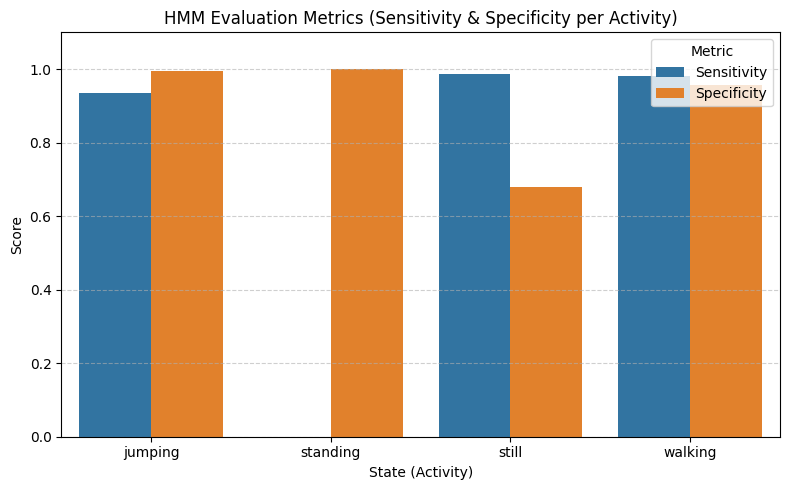

Saved Figure 4 -> figure4_hmm_metrics.png


In [ ]:
# HMM Evaluation Metrics (Sensitivity, Specificity, Accuracy)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# try loading your existing metrics file
if Path("hmm_metrics_table.csv").exists():
    metrics = pd.read_csv("hmm_metrics_table.csv")
else:
    # fallback demo data if not available
    metrics = pd.DataFrame({
        "State (Activity)": ["jumping","standing","still","walking"],
        "Sensitivity": [0.934, 0.000, 0.988, 0.980],
        "Specificity": [0.994, 1.000, 0.679, 0.958],
        "Accuracy": [0.723, 0.723, 0.723, 0.723]
    })

# clean column names if necessary
metrics.columns = [c.strip() for c in metrics.columns]
metrics = metrics[metrics["State (Activity)"].str.lower() != "overall accuracy"]

# reshape for plotting
plot_df = metrics.melt(id_vars="State (Activity)",
                       value_vars=["Sensitivity", "Specificity"],
                       var_name="Metric", value_name="Score")

# --- plot ---
plt.figure(figsize=(8,5))
sns.barplot(data=plot_df, x="State (Activity)", y="Score", hue="Metric")
plt.title("HMM Evaluation Metrics (Sensitivity & Specificity per Activity)", fontsize=12)
plt.ylim(0,1.1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("figure4_hmm_metrics.png", dpi=200)
plt.show()

print("Saved Figure 4 -> figure4_hmm_metrics.png")

In [ ]:
# === FIXED SAVE CELL: converts non-JSON types before saving ===
import os, json
import numpy as np
import pandas as pd
from pathlib import Path

out_dir = Path("results")
out_dir.mkdir(exist_ok=True)

# 1) HMM params (already working for you)
if 'params' in globals():
    np.save(out_dir / "transition_matrix.npy", params["A"])
    np.save(out_dir / "initial_probs_pi.npy", params["pi"])
    np.save(out_dir / "emission_means.npy", params["means"])
    np.save(out_dir / "emission_vars.npy", params["vars"])
    print(" Saved HMM parameters: A, pi, means, vars")
else:
    print(" 'params' not found. Re-run the training cell first.")

# 2) State→label mapping (CAST KEYS TO STRING to satisfy json)
if 'state_to_label' in globals():
    # convert keys and values to JSON-safe types
    state_to_label_json = {str(int(k)): (str(v) if not isinstance(v, str) else v)
                           for k, v in state_to_label.items()}
    with open(out_dir / "state_to_label.json", "w") as f:
        json.dump(state_to_label_json, f, indent=2)
    print(" Saved state_to_label.json")
else:
    print(" 'state_to_label' not found. Re-run the decoding cell.")

# 3) Confusion matrix & labels (guarded)
if 'cm' in globals() and 'labels' in globals():
    pd.DataFrame(cm, index=labels, columns=labels).to_csv(out_dir / "confusion_matrix.csv")
    print(" Saved confusion_matrix.csv")
else:
    print(" 'cm' or 'labels' not found. Re-run the evaluation cell.")

# 4) Metrics table
if Path("hmm_metrics_table.csv").exists():
    pd.read_csv("hmm_metrics_table.csv").to_csv(out_dir / "evaluation_metrics.csv", index=False)
    print(" Saved evaluation_metrics.csv (from hmm_metrics_table.csv)")
elif 'metrics_df2' in globals():
    metrics_df2.to_csv(out_dir / "evaluation_metrics.csv", index=False)
    print(" Saved evaluation_metrics.csv from metrics_df2")
elif 'metrics_df' in globals():
    metrics_df.to_csv(out_dir / "evaluation_metrics.csv", index=False)
    print(" Saved evaluation_metrics.csv from metrics_df")
else:
    print(" No metrics DataFrame found. Re-run the metrics cell.")

print(f"\nArtifacts are in: {out_dir.resolve()}")

 Saved HMM parameters: A, pi, means, vars
 Saved state_to_label.json
 Saved confusion_matrix.csv
 Saved evaluation_metrics.csv (from hmm_metrics_table.csv)

Artifacts are in: /content/results


In [ ]:
from google.colab import files
files.download("results/transition_matrix.npy")
files.download("results/initial_probs_pi.npy")
files.download("results/emission_means.npy")
files.download("results/emission_vars.npy")
files.download("results/confusion_matrix.csv")
files.download("results/evaluation_metrics.csv")
files.download("results/state_to_label.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r results.zip results
from google.colab import files
files.download("results.zip")

  adding: results/ (stored 0%)
  adding: results/evaluation_metrics.csv (deflated 23%)
  adding: results/confusion_matrix.csv (deflated 49%)
  adding: results/emission_means.npy (deflated 91%)
  adding: results/transition_matrix.npy (deflated 70%)
  adding: results/emission_vars.npy (deflated 91%)
  adding: results/state_to_label.json (deflated 30%)
  adding: results/initial_probs_pi.npy (deflated 53%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>